# Sentiment Analysis

Is it possible to track the positivity and negativity of MP's tweets? Let's attempt this by:

1. Train a classifier
2. Run it on the tweets in tweets.csv

## Stage 1: Train a Classifier

Use NLTK and Sklearn to create a classifier for the sentiment of tweets.

In [59]:
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [2]:
#nltk.download()
# if you haven't already - download the twitter_samples corpus

### Training Data

Use the tweets from the training data in the nltk corpus.

This is a set of tweets labelled as either positive or negative in sentiment.

Hopefully these will generalise to the MP tweet dataset. Further work could involve investigating other training sets.

In [3]:
twitter_samples = nltk.corpus.twitter_samples

In [4]:
# What files have we got?
twitter_samples.fileids() 

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [5]:
# Put data into a dataframe

pos_df = pd.DataFrame()
neg_df = pd.DataFrame()

pos_tweets = []
neg_tweets = []

strings = twitter_samples.strings('positive_tweets.json')
for string in strings:
    pos_tweets.append(string)
    
strings = twitter_samples.strings('negative_tweets.json')
for string in strings:
    neg_tweets.append(string)

In [6]:
pos_df['text'] = pos_tweets
neg_df['text'] = neg_tweets

In [7]:
pos_df['class'] = 1
neg_df['class'] = 0

In [8]:
tweet_df = pos_df.append(neg_df)

### Pre-Process Text

* Remove URLs and smileys.

The data was put into the positive class if it contains a :) and the negative class if it contains a :( This will mess up testing so remove for now.

Although maybe leaving them in will be good for when we analyse the MP's tweets.

In [9]:
def process_text(row):
    """
    Remove URLs, mentions, hashtags and smileys from text
    
    """
    
    string = row['text'] 
    
    string = re.sub(r'http\S*\b', '', string)
    string = re.sub(r'pic.\S*\b', '', string)
    string = re.sub(r':', '', string)
    string = re.sub(r'\)', '', string)   
    string = re.sub(r'\(', '', string)
    string = re.sub(r'@\S*\b', '', string)
    string = re.sub(r'#', '', string)    
    
    return string

In [10]:
tweet_df['processed_text'] = tweet_df[['text']].apply(process_text, axis=1)

In [33]:
tweet_df.head()

,text,class,processed_text
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,FollowFriday for being top engaged members ...
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,Hey James! How odd / Please call our Contact ...
2,@DespiteOfficial we had a listen last night :)...,1,we had a listen last night As You Bleed is a...
3,@97sides CONGRATS :),1,CONGRATS
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,yeaaaah yippppy!!! my accnt verified rqst has...


### Build and Train a Model

We will use a standard document classifier using sklearn. Each tweet is classified as either 1=positive or 0=negative.

Three stages to the classifier:

1. CountVectorizer - make a sparse array of the words in the corpus along with the frequencies.
2. tf-idf - Adjust the frequency this for tweet length and how often it occurs in other documents. See wiki for more info
3. Train classifier. We will try Naïve Bayes and a SVM.


Some things to consider:

1. Do we get rid of URLs?


In [11]:
# split into data and target

X = tweet_df['processed_text']
y = tweet_df['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
# Make a pipeline

stop_words = nltk.corpus.stopwords.words('english')

tweet_classifier = Pipeline([('count_vectorise', CountVectorizer(tokenizer=word_tokenize,stop_words=stop_words)),
    ('tf-idf', TfidfTransformer()),
    ('classify', MultinomialNB()),
    ])

In [14]:
tweet_classifier.fit(X_train, y_train)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Pipeline(steps=[('count_vectorise', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=..._tf=False, use_idf=True)), ('classify', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [15]:
pred = tweet_classifier.predict(X_test)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [16]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.77      0.73      0.75      1539
          1       0.73      0.77      0.75      1461

avg / total       0.75      0.75      0.75      3000



In [18]:
print(confusion_matrix(y_test, pred))

[[1130  409]
 [ 341 1120]]


## Stage 2 - Apply to MP Dataset

In [25]:
#get mp tweet dataset

mp_tweets = pd.read_csv('../data/processed_tweets.csv')

In [26]:
mp_tweets = mp_tweets.drop('Unnamed: 0', axis=1)

In [27]:
mp_tweets.head()

,user_name,constituency,party,gender,tweet_id,permalink,text,date,retweets,favourites,replies,party_new
0,skinnock,Aberavon,Labour,Male,947017416047058944,https://twitter.com/SKinnock/status/9470174160...,Devastating resignation letter from Andrew Ado...,2017-12-30 08:12:01,17,43,11,Labour
1,skinnock,Aberavon,Labour,Male,944285195372548097,https://twitter.com/SKinnock/status/9442851953...,The gov need to act to allow more flexibility ...,2017-12-22 19:15:09,2,5,2,Labour
2,skinnock,Aberavon,Labour,Male,943841995390423040,https://twitter.com/SKinnock/status/9438419953...,Here are the fabled sector analyses. Damp squi...,2017-12-21 13:54:02,21,29,8,Labour
3,skinnock,Aberavon,Labour,Male,943595206225559552,https://twitter.com/SKinnock/status/9435952062...,"Fallon, Patel and now Green. Three strikes and...",2017-12-20 21:33:22,7,31,5,Labour
4,skinnock,Aberavon,Labour,Male,943552279189258245,https://twitter.com/SKinnock/status/9435522791...,Waiting to hear from @DavidGauke re my concern...,2017-12-20 18:42:48,3,1,1,Labour


In [35]:
# Now preprocess the data.
# N.B - slightly different as we have spaces within the URLs in this dataset.

def process_text_mp(row):
    """
    Remove URLs, mentions, hashtags and smileys from text
    
    """
    
    string = row['text']
    
    if pd.isna(string):
        
        return ''
    
    string = re.sub(r'(http|pic.).*$', '', string)
    string = re.sub(r'pic.\S*\b', '', string)
    string = re.sub(r':', '', string)
    string = re.sub(r'\)', '', string)   
    string = re.sub(r'\(', '', string)
    string = re.sub(r'@\S*\b', '', string)
    string = re.sub(r'#', '', string)    
    
    return string

In [36]:
mp_tweets['processed_text'] = mp_tweets[['text']].apply(process_text_mp, axis=1)

In [38]:
X = mp_tweets['processed_text']

In [39]:
y = tweet_classifier.predict(X)

/Applications/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Step 3 - Analyse Data

In [41]:
#Attach to mp_tweet dataframe

mp_tweets['sentiment'] = y

In [43]:
#What are the proportions?
mp_tweets['sentiment'].value_counts()

1    1790139
0     927864
Name: sentiment, dtype: int64

/Applications/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


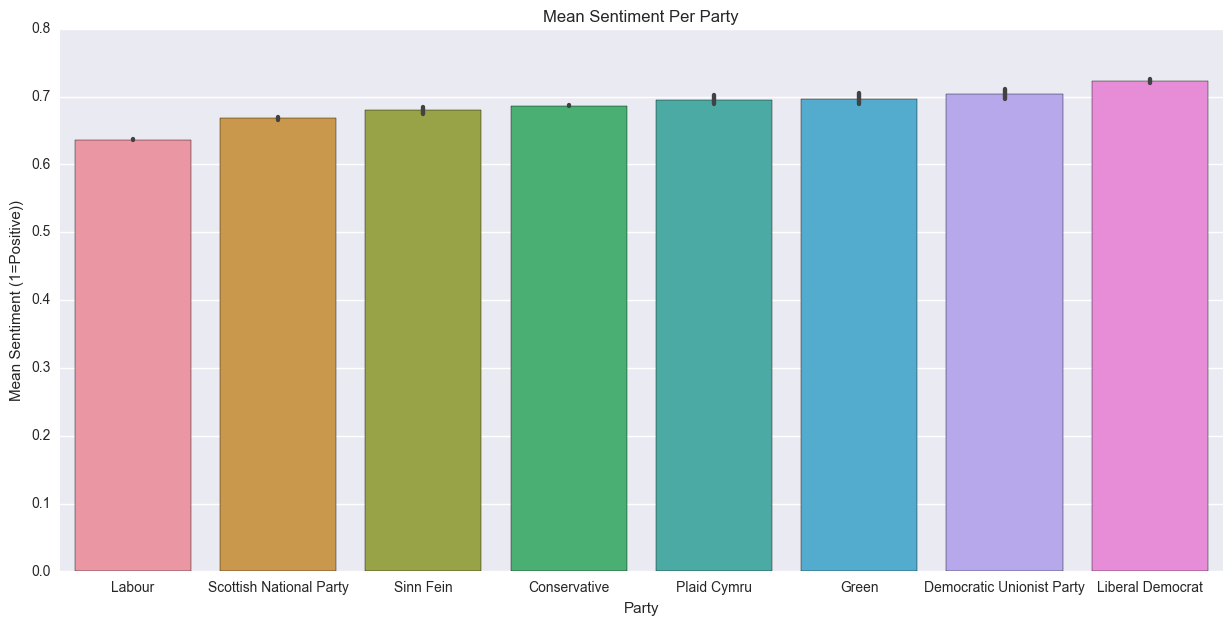

In [87]:
# Look on a per party basis

order =list(mp_tweets.groupby('party_new').mean()['sentiment'].sort_values(ascending=True).index)

fig, ax = plt.subplots(figsize=(15,7))

sns.barplot(x='party_new', y='sentiment', data=mp_tweets, order=order)

plt.title('Mean Sentiment Per Party')
plt.xlabel('Party')
plt.ylabel('Mean Sentiment (1=Positive))')

### Sentiment Change Over Time

In [58]:
mp_tweets['date'] = pd.to_datetime(mp_tweets['date'])

def get_day_of_week(row):
    
    return row['date'].weekday()

def get_hour_of_day(row):
    
    return row['date'].hour
    
def year_month(row):
    
    return '{year}-{month}'.format(year=row['date'].year, month=row['date'].month)

def unique_day(row):
    
    return str(row['date'].date())

df['day'] = df[['date']].apply(get_day_of_week, axis=1)
df['hour'] = df[['date']].apply(get_hour_of_day, axis=1)
df['year_month'] = df[['date']].apply(year_month, axis=1)
df['unique_day'] = df[['date']].apply(unique_day, axis=1)

In [61]:
grouped = mp_tweets[['sentiment', 'year_month', 'party_new']].groupby(['year_month', 'party_new']).mean()

In [62]:
grouped.head()

sentiment
year_month party_new                  
2007-12    Labour             0.769231
2008-1     Labour             0.704545
2008-10    Conservative       0.727273
           Labour             0.586957
           Liberal Democrat   0.260870

In [63]:
grouped.reset_index(inplace=True)
grouped['year_month'] =pd.to_datetime(grouped['year_month'])

In [64]:
grouped.head()

,year_month,party_new,sentiment
0,2007-12-01,Labour,0.769231
1,2008-01-01,Labour,0.704545
2,2008-10-01,Conservative,0.727273
3,2008-10-01,Labour,0.586957
4,2008-10-01,Liberal Democrat,0.260870


In [65]:
grouped = grouped[grouped['year_month'] < '2017-12-01']

In [66]:
time_data = grouped.pivot_table(index='year_month', columns='party_new')

time_data.columns = time_data.columns.droplevel()

In [67]:
time_data.head()

party_new,Conservative,Democratic Unionist Party,Green,Labour,Liberal Democrat,Plaid Cymru,Scottish National Party,Sinn Fein
year_month,,,,,,,,
2007-12-01,NaN,NaN,NaN,0.769231,NaN,NaN,NaN,NaN
2008-01-01,NaN,NaN,NaN,0.704545,NaN,NaN,NaN,NaN
2008-02-01,NaN,NaN,NaN,0.692308,NaN,NaN,NaN,NaN
2008-03-01,0.487179,NaN,NaN,0.752941,NaN,NaN,NaN,NaN
2008-04-01,0.645161,NaN,NaN,0.747573,NaN,NaN,NaN,NaN


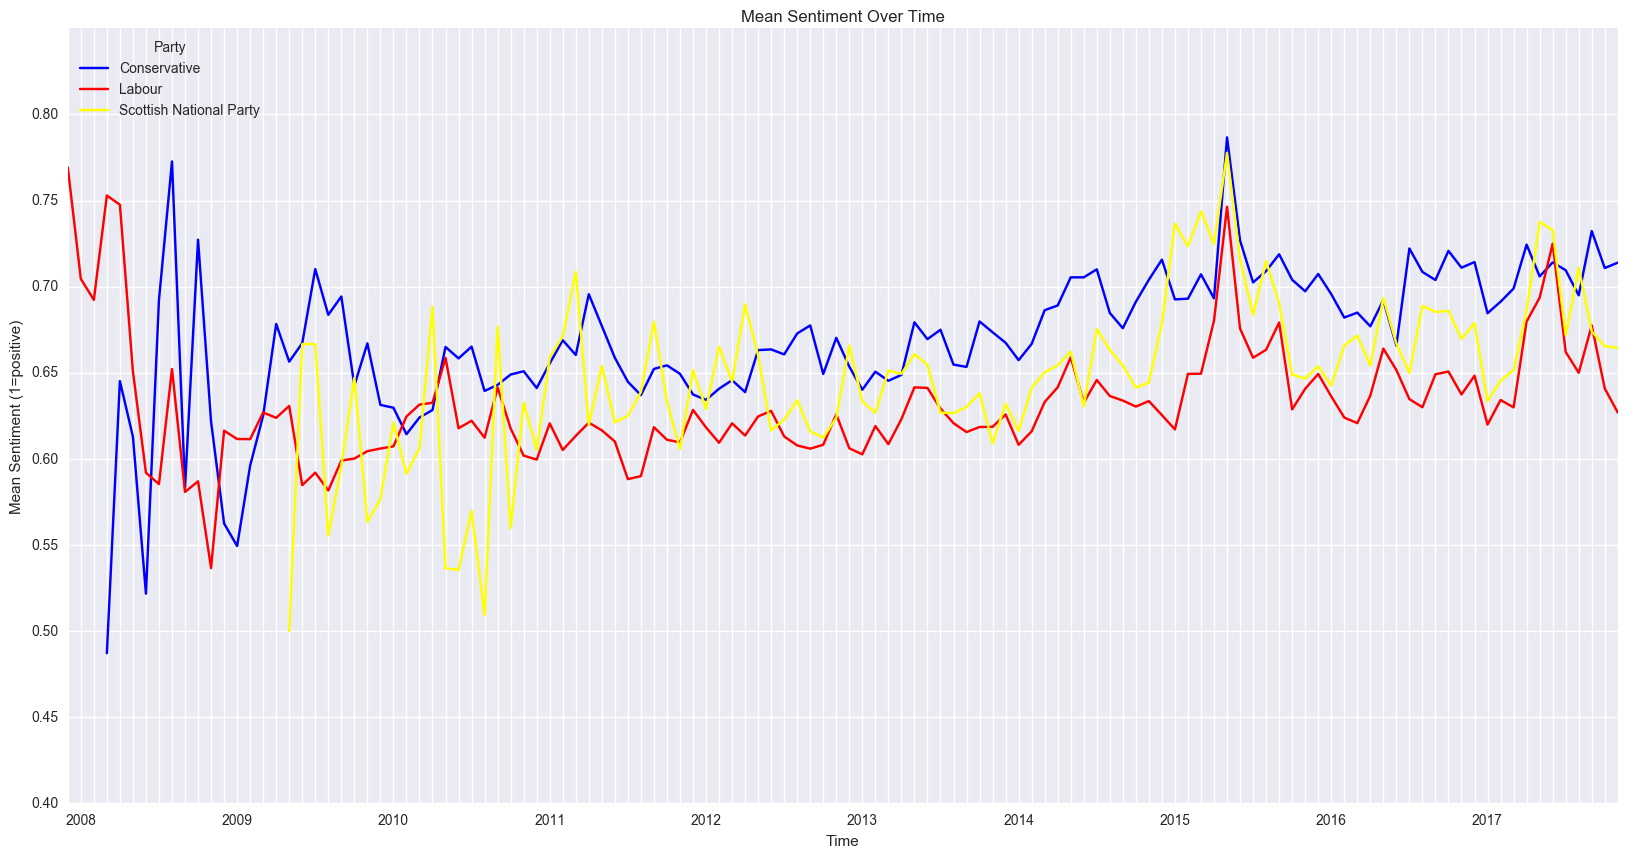

In [76]:
fig, ax = plt.subplots(figsize=(20,10))
colours = ['b', 'r', 'yellow']
time_data[['Conservative', 'Labour', 'Scottish National Party']].plot(ax=ax, color=colours,xticks=time_data.index)
plt.title('Mean Sentiment Over Time')
plt.ylabel('Mean Sentiment (1=positive)')
plt.xlabel('Time')
plt.ylim(0.4,0.85)
plt.legend(title='Party', loc='upper left')